# Analyzing DTM Results
#https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb

In [1]:
import pickle
import pyLDAvis
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.special import logsumexp
import scipy as sp
from collections import OrderedDict, defaultdict

#set precision for pandas
pd.set_option("display.precision", 10)
 

# Set topic number

In [3]:
model = pickle.load(open("/Users/carlyknight/Documents/Data/FuturePerfect/dynamic_topic_models/topic50.pkl", "rb" ) )
#print model attirbutes
print(model.__dict__.keys())

dict_keys(['dtm_path', 'id2word', 'num_terms', 'num_topics', 'lencorpus', 'prefix', 'time_slices', 'lda_sequence_min_iter', 'lda_sequence_max_iter', 'lda_max_em_iter', 'alpha', 'top_chain_var', 'rng_seed', 'initialize_lda', 'lambda_', 'obs_', 'lhood_', 'gamma_', 'init_alpha', 'init_beta', 'init_ss', 'em_steps', 'influences_time'])


In [4]:
number_topic = model.num_topics
number_topic

50

In [5]:
corpus = pickle.load(open('/Users/carlyknight/Documents/Data/FuturePerfect/dynamic_topic_models/corpus.pkl', 'rb') )

### IDENTIFY FREQUENT TERMS (FREX WORDS)

### extract term-topic matrix (note this will be over all the time slices)

# get_topics for DTM
#get_topics()
#Get the term-topic matrix learned during inference.

#Returns
#The probability for each word in each topic, shape (num_topics, vocabulary_size).

#Return type
#numpy.ndarray

#https://stackoverflow.com/questions/42289858/extract-topic-word-probability-matrix-in-gensim-ldamodel

In [6]:
def ecdf(arr):
    """Calculate the ECDF values for all elements in a 1D array."""
    return sp.stats.rankdata(arr, method='max') / arr.size

In [7]:
def get_topics(model, time):
    topic_terms = model.lambda_

    #timeslice
    timeslice = [ "ts_" + str(i) for i in range(topic_terms.shape[2])]

    # find the right word based on column index
    words = [model.id2word[i] for i in range(topic_terms.shape[1])]

    #apply words over 40 topics, generate list of dataframes, columns are time-slices
    word_time_topic_matrix=[]

    for j in range(topic_terms.shape[0]):
        temp = topic_terms[j]
        temp=pd.DataFrame(temp,columns=timeslice)
        temp['word'] = words
        temp=temp.set_index('word')
        word_time_topic_matrix.append(temp)
    
    #reshape dataframe so that its one dataframe per topic, columns are topics
    topic_term_matrix=[ ]

    for i in timeslice:
        temp =pd.concat([df[[i]] for df in word_time_topic_matrix], axis=1)
        temp.columns = ["topic_" + str(i) for i in range(number_topic)]
        topic_term_matrix.append(temp)
    
    #now, invert so shape is (num_topics, vocabulary_size)
    term_topic_matrix = [df.transpose() for df in topic_term_matrix] 
        
    #convert estimates to probability (sum equals to 1 per topic)
    term_topic_proba = np.apply_along_axis(lambda x: x/x.sum(),1,term_topic_matrix[time])
    term_topic_proba1 = pd.DataFrame(term_topic_proba,columns=words)
    
    return term_topic_proba1
    

### Calculate FREX for all words in a topic model
#see R STM package for details

#https://gist.github.com/jrnold/daa039f02486009a24cf3e83403dabf0

In [8]:
"""Calculate FREX scores for all words in a topic model.

See R STM package for details.

"""
def frex(topics_matrix, w):
    log_beta = np.log(topics_matrix)
    log_exclusivity = log_beta - logsumexp(log_beta, axis=0)
    #log_exclusivity = (log_beta.transpose() - logsumexp(log_beta, axis=0)).transpose()
    exclusivity_ecdf = np.apply_along_axis(ecdf, 1, log_exclusivity)
    freq_ecdf = np.apply_along_axis(ecdf, 1, log_beta)
    #out = 1. /(w / freq_ecdf + (1 - w) / exclusivity_ecdf )
    out = exclusivity_ecdf
    return out


In [9]:
def word_freq(corpus):
    """Calculate word frequencies in a ``corpus``."""
    counts = defaultdict(int)
    for doc in corpus:
        for word, count in doc:
            counts[word] += count
    total = sum(counts.values())
    nwords = max(counts.keys())
    out = np.zeros(nwords + 1)
    for k, v in counts.items():
        out[k] = v / total
    return out

In [10]:
def create_topic_word_data(model, corpus, frex_w, time):
    """Create data frame with topic-word information.
    Parameters
    ------------
    model: Fitted dTM model
    corpus: list
    frex_w: float
        Weight to use in FREX calculations.

    Returns
    ---------
    :class:`pandas.DataFrame`
        Data frame with the following columns.

        :word: ``str``. Word
        :word_id: ``float``. Word identifier
        :topic: ``int``. Topic number
        :prob: ``float``. Probability of the word conditional on a topic.
        :frex: ``float``. FREX score
    """
    #word ids
    id2word = model.id2word
    words = pd.DataFrame({
        'word_id': list(id2word.keys()),
        'word': list(id2word.values())
         }, columns=("word_id", "word"))
    #get probabilities
    topics_matrix = pd.DataFrame(get_topics(model, time))
    #organize
    term_topics = topics_matrix
    term_topics.index.name = "topic"
    term_topics=term_topics.stack().reset_index()
    term_topics.columns = ["topic", "word", "prob"]
    term_topics=term_topics.merge(words, left_on="word", right_on="word")
    term_topics.columns = ['topic', 'word', 'prob', 'word_id'] #Step 5: merge back in 
    # need to ensure that the array's are flattened in the right order
    term_topics['frex'] = np.ravel(frex(topics_matrix, w=frex_w), order="F")
    return term_topics




## Frex output

In [11]:
#run frex models, time = 78
frex_output = create_topic_word_data(model, corpus, frex_w =.5, time = 78)

In [12]:
#return frex words
def get_frex_words(frex_output, number_topic, topn):
    frexlist = frex_output.loc[frex_output['topic'] == number_topic].sort_values(by = "frex", ascending = True)['word'].tolist()
    frexlist = frexlist[0:topn]
    return frexlist

# Get Topic Descriptions

In [14]:
for i in range(0,number_topic):
    print("TOPIC ", i)
    topics=model.show_topic(topicid=i, time=75, topn=8)
    topic_words =[word for number, word in topics]
    print("PROB WORDS:", topic_words)
    frex_words = get_frex_words(frex_output, number_topic = i, topn=8)
    print("FREX WORDS:", frex_words)
    print(" ")
    

TOPIC  0
PROB WORDS: ['insur', 'life', 'premium', 'claim', 'annuiti', 'reinsur', 'policyhold', 'underwrit']
FREX WORDS: ['policyhold', 'insur', 'reinsur', 'annuiti', 'safeco', 'underwrit', 'life', 'allstat']
 
TOPIC  1
PROB WORDS: ['network', 'hotel', 'commun', 'internet', 'properti', 'wireless', 'senior', 'revenu']
FREX WORDS: ['hotel', 'wireless', 'network', 'internet', 'marriott', 'broadband', 'digit', 'fcc']
 
TOPIC  2
PROB WORDS: ['energi', 'power', 'electr', 'txu', 'ga', 'corp', 'fuel', 'risk']
FREX WORDS: ['energi', 'xcel', 'txu', 'nrg', 'decommiss', 'nuclear', 'ga', 'electr']
 
TOPIC  3
PROB WORDS: ['presid', 'vice', 'divis', 'chairman', 'execut', 'york', 'group', 'chief']
FREX WORDS: ['vice', 'presid', 'chairman', 'men', 'shoe', 'robert', 'treasur', 'apparel']
 
TOPIC  4
PROB WORDS: ['environment', 'site', 'remedi', 'liabil', 'segment', 'chemic', 'currenc', 'technolog']
FREX WORDS: ['eastman', 'environment', 'remedi', 'cleanup', 'prp', 'currenc', 'site', 'chemic']
 
TOPIC  5
P

FREX WORDS: ['caterpillar', 'truck', 'engin', 'boat', 'tractor', 'car', 'cummin', 'automot']
 
TOPIC  47
PROB WORDS: ['chemic', 'research', 'divis', 'plastic', 'fiber', 'rubber', 'tire', 'resin']
FREX WORDS: ['chemic', 'plastic', 'rubber', 'resin', 'fiber', 'tire', 'polyest', 'textil']
 
TOPIC  48
PROB WORDS: ['paper', 'pulp', 'wood', 'machin', 'timber', 'forest', 'packag', 'lumber']
FREX WORDS: ['pulp', 'paper', 'timber', 'forest', 'wood', 'lumber', 'paperboard', 'machin']
 
TOPIC  49
PROB WORDS: ['risk', 'fair', 'hedg', 'flow', 'liabil', 'oblig', 'impact', 'impair']
FREX WORDS: ['hedg', 'swap', 'sfa', 'impair', 'risk', 'goodwil', 'currenc', 'postretir']
 


In [15]:
#create top six words
keywords = []

for i in range(0,number_topic):
    topics=model.show_topic(topicid=i, time=75, topn=6)
    words=" ".join([word for number, word in topics])
    keywords.append(words)

In [16]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
#https://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/

# Topics over time
#https://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/
#https://radimrehurek.com/gensim/models/ldamodel.html

### open metadata

In [17]:
file_loc = "/Users/carlyknight/Documents/Data/Annual Report/report_paragraphs/future_texts/"

#limit to over 1930
metadata = pd.read_csv(file_loc + "metadata_futureperfect.csv") 
metadata = metadata[(metadata['Year'] >= 1930)]
metadata['text_filename'] = metadata['Filename'].str.replace(".xml", ".txt")

# Get document-topic weights

In [18]:
#create document-topic matrix
num_docs = model.lencorpus
data = []

for j in range(0, num_docs):
    doc_topics = [model.gamma_[j, i] for i in range(0, number_topic)]
    data.append(doc_topics)
    
topic_document_distribution = pd.DataFrame(data)
topic_document_distribution.shape


(36479, 50)

In [19]:
#check to make sure weights load to 1:
sumweights= topic_document_distribution.sum(axis=1)
for i, doc in enumerate(sumweights):
    if doc !=1:
        continue
        #print("Doc ", i, " does not equal 1: ", doc )

In [20]:
#basically loads to 1

#pull in metadata
names = [i for i in metadata['Filename']]
topic_document_distribution['Filename'] = names
years = [i for i in metadata['Year']]
topic_document_distribution['Year'] = years

topic_document_distribution.to_csv("/Users/carlyknight/Dropbox/PROJECTS/ConceptionsofRisk/data/dtm/topic_document_distribution.csv")

#convert dataset to long
dtm = pd.melt(topic_document_distribution, id_vars=["Filename", "Year"], var_name= "topic", value_name='weight')
dtm=dtm.sort_values(by = ["Year", "Filename", "topic"])
print(dtm.head())

            Filename  Year topic        weight
21217   88178299.xml  1930     0  0.0002816901
57696   88178299.xml  1930     1  0.0002816901
94175   88178299.xml  1930     2  0.0002816901
130654  88178299.xml  1930     3  0.0002816901
167133  88178299.xml  1930     4  0.0002816901


In [21]:
#put in topic keywords
dfkeys = pd.DataFrame(keywords)
dfkeys.columns = ['keywords']
dfkeys['topic'] = range(0,number_topic)

#merge
dtm=dtm.merge(dfkeys, left_on='topic', right_on='topic')
print(dtm.head())

       Filename  Year topic        weight  \
0  88178299.xml  1930     0  0.0002816901   
1  88178309.xml  1930     0  0.3015142741   
2  88178340.xml  1930     0  0.0001058201   
3  88178352.xml  1930     0  0.0010526316   
4  88178376.xml  1930     0  0.0010526316   

                                   keywords  
0  insur life premium claim annuiti reinsur  
1  insur life premium claim annuiti reinsur  
2  insur life premium claim annuiti reinsur  
3  insur life premium claim annuiti reinsur  
4  insur life premium claim annuiti reinsur  


# Summary Statistics

In [22]:
dtm_sum = dtm[dtm['weight'] != 0]

print("Max: {}".format(dtm_sum['weight'].max()))
print("Min: {}".format(dtm_sum['weight'].min()))
print("Average: {}".format(dtm_sum['weight'].mean()))
print("Median: {}".format(dtm_sum['weight'].median()))
print("Most frequent value: {}".format(dtm_sum['weight'].round(3).value_counts().idxmax()))


Max: 0.9970919881305638
Min: 2.0243544413608883e-07
Average: 0.020000000000013115
Median: 2.9629629629629647e-05
Most frequent value: 0.0


# Graph over time

In [23]:
# Get number of docs per year
total_docs = dtm.groupby('Year')['Filename'].apply(lambda x: len(x.unique())).reset_index()
total_docs.columns = ['Year', 'total_docs']

# Group by year and topic id
dtm_avg = dtm.groupby(['Year', 'topic'])['weight'].sum().reset_index()

# Merge dataframes
dtm_avg_1 = dtm_avg.merge(total_docs, on="Year", how="left")

# Compute the mean per topic
dtm_avg_1['average_weight'] = dtm_avg_1['weight'] / dtm_avg_1['total_docs']

#merge in labels
labels= dtm[['topic', 'keywords']].drop_duplicates()
dtm_avg_2 = dtm_avg_1.merge(labels, on='topic')

dtm_time = dtm_avg_2

In [24]:
#Create plot
def create_pointplot(df, y_value, hue=None, col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.factorplot(x="Year", y=y_value, kind='point', hue=hue, 
                       col=col, col_wrap=wrap,  size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p


def create_bar(df, y_value, hue=None, col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.factorplot(x="Year", y=y_value, kind='bar', hue=hue, 
                       col=col, col_wrap=wrap, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p


# Plots

/Users/carlyknight/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/carlyknight/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/carlyknight/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/carlyknight/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWa

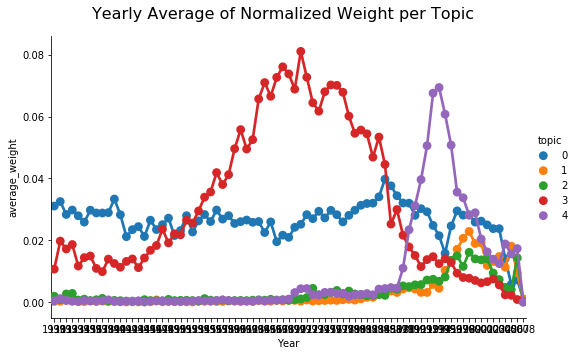

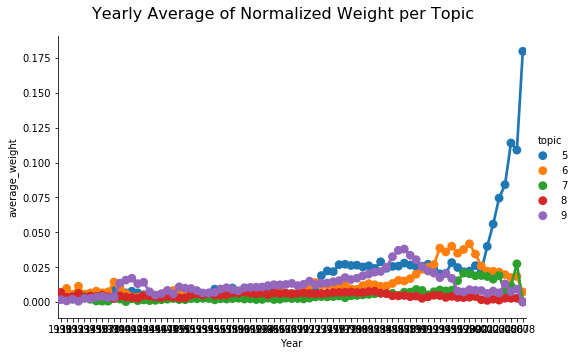

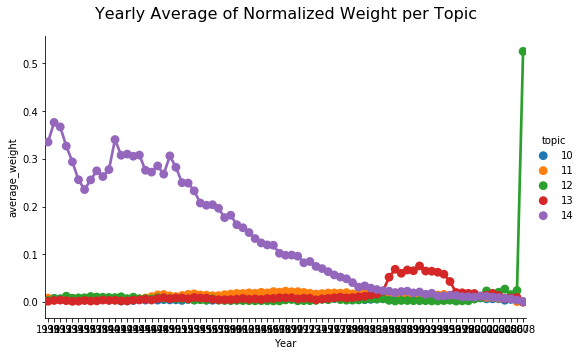

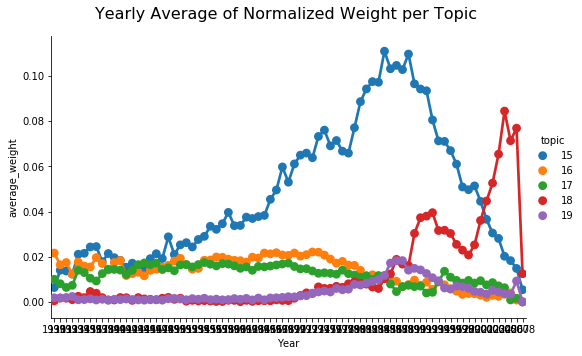

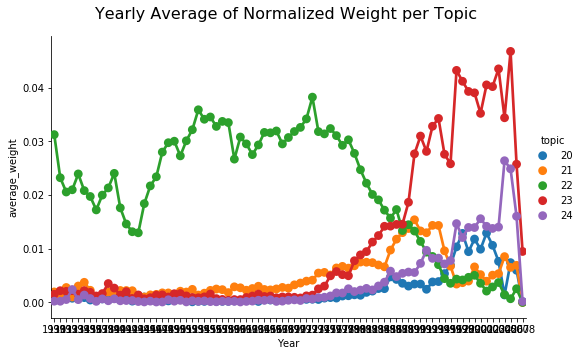

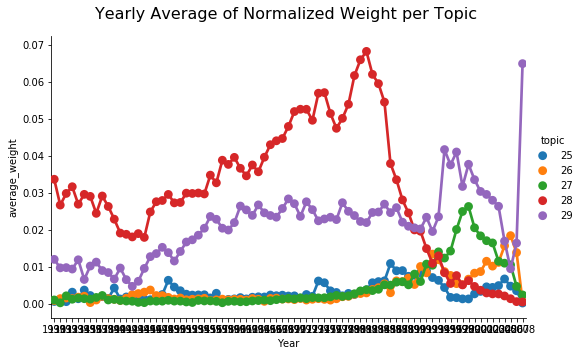

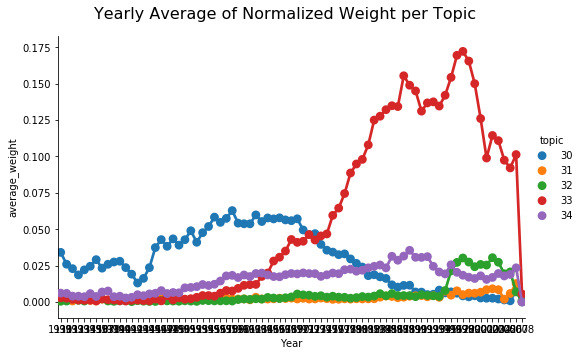

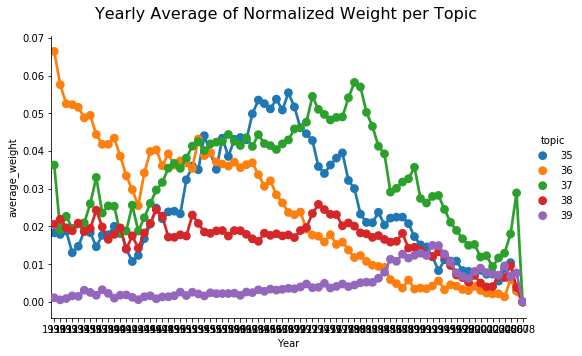

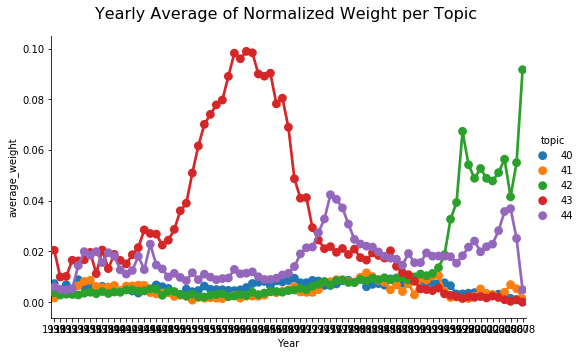

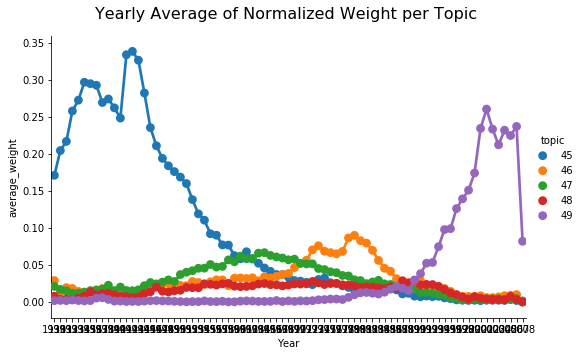

In [25]:
for i in range(0, number_topic, 5):
    dfs = dtm_time[(dtm_time['topic'] >= i) & (dtm_time['topic'] < i +5 )]
    create_pointplot(dfs, 'average_weight', hue="topic",
                title="Yearly Average of Normalized Weight per Topic")
